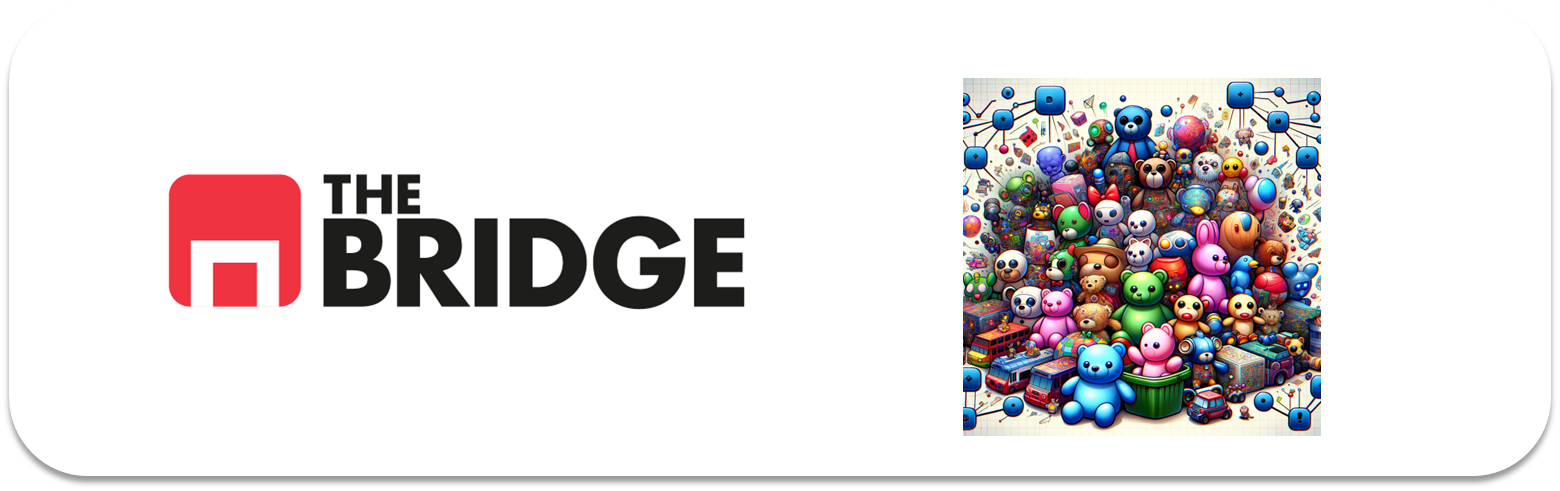

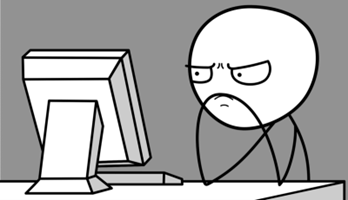

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import warnings

In [26]:
%matplotlib inline
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferencia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores para ver si vosotros podéis ayudarles a encontrar algún tipo de segmentación que luego ellos se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [27]:
drinks = r"https://raw.githubusercontent.com/rodolso/DS_Online_Octubre24_Exercises/refs/heads/main/04_Machine_Learning/Sprint_13/Unidad_02/Practica_Obligatoria/data/empowering_drinks.csv"
new_exper = r"https://raw.githubusercontent.com/rodolso/DS_Online_Octubre24_Exercises/refs/heads/main/04_Machine_Learning/Sprint_13/Unidad_02/Practica_Obligatoria/data/new_experiments.csv"
pow_results = r"https://raw.githubusercontent.com/rodolso/DS_Online_Octubre24_Exercises/refs/heads/main/04_Machine_Learning/Sprint_13/Unidad_02/Practica_Obligatoria/data/power_results.csv"

In [28]:
drinks_df = pd.read_csv(drinks, sep = "|")
drinks_df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [29]:
drinks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [30]:
drinks_df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


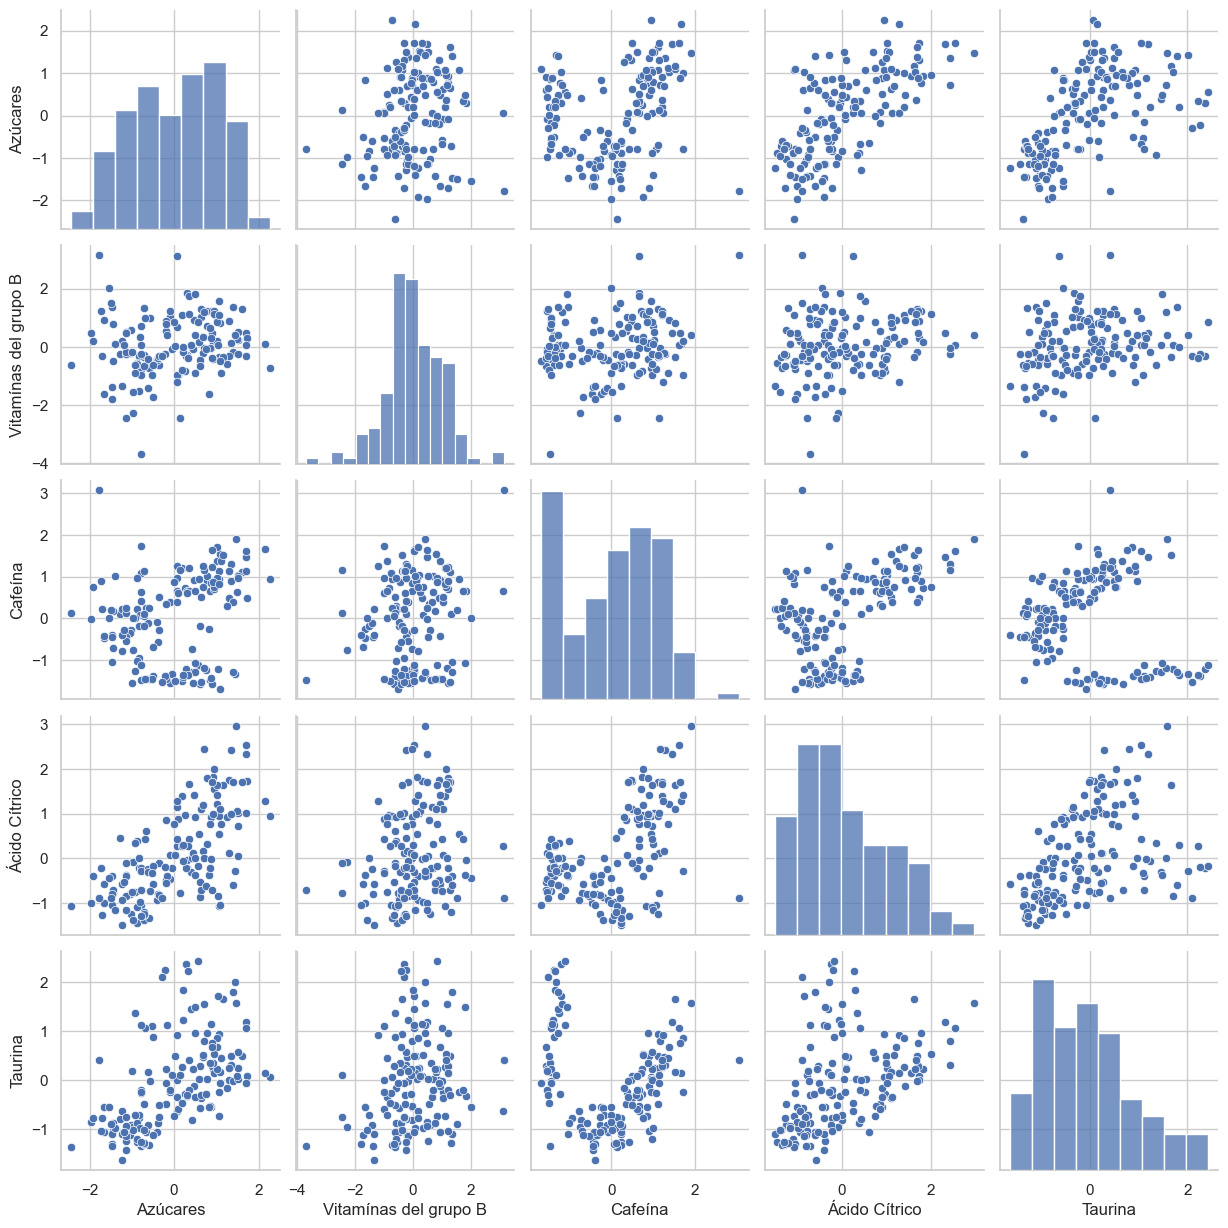

In [31]:
sns.pairplot(drinks_df)
plt.show()

In [32]:
# Feature selection (filter methods)
corr_matrix = drinks_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
data_clean = drinks_df.drop(to_drop, axis=1)

In [33]:
# Estandarización
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

In [34]:
# Ajustar hiperparámetros
dbscan = DBSCAN(eps=0.6, min_samples=3)
clusters_db = dbscan.fit_predict(data_scaled)

# Número de clusters (excluyendo ruido)
n_clusters_db = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
print(f"DBSCAN encontró {n_clusters_db} clusters")

DBSCAN encontró 10 clusters


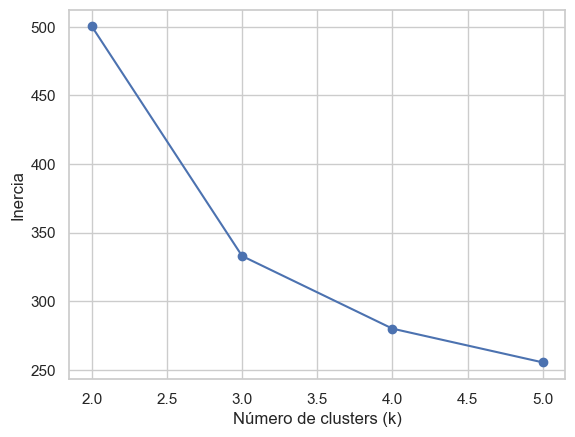

In [35]:
# Método del codo para elegir k
inertia = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 6), inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.show()

In [36]:
# K selection
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_km = kmeans.fit_predict(data_scaled)

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [37]:
new_data = pd.read_csv(new_exper, sep = "|")
new_data_scaled = scaler.transform(new_data)  # Usar mismo scaler

# Usar K-means (más estable para nuevos datos)
new_clusters = kmeans.predict(new_data_scaled)

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [38]:
# Cargar etiquetas de "energización"
pow_df = pd.read_csv(pow_results).iloc[:len(clusters_km)]

# Evaluar K-means
ari_km = adjusted_rand_score(pow_df["class"], clusters_km)
print(f"Índice Rand Ajustado (K-means): {ari_km:.2f}")

# Evaluar DBSCAN (si hay coincidencia en clusters)
ari_db = adjusted_rand_score(pow_df["class"], clusters_db)
print(f"Índice Rand Ajustado (DBSCAN): {ari_db:.2f}")

Índice Rand Ajustado (K-means): 0.91
Índice Rand Ajustado (DBSCAN): 0.02


In [39]:
z = pd.read_csv(pow_results)
z.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   159 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB
